# <font color='red'>**Sequence to sequence implementation**</font>

## Simple Encoder and Decoder
Implement simple Encoder-Decoder model

In [ ]:
import pandas as pd
import numpy as  np
import pandas as pd
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import stopwords
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('ita.txt', sep = '\t', header = None, names = ['English', 'Italian', 'Info'], usecols = [0, 1])
data.head()

<font color='blue'>**Preprocess data**</font>

In [ ]:
stop_words = set(stopwords.words('english')) 
def preprocess(text_data):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    text = []
    for sentance in tqdm(text_data):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = sentance.lower()
        text.append(sentance.strip())
    return np.array(text)

In [ ]:
eng = preprocess(data.English.values)

In [ ]:
ita = preprocess(data.Italian.values)

In [ ]:
df = pd.DataFrame()
df['English']  = eng
df['Italian'] = ita
df.head(2)

,English,Italian
0,hi,ciao
1,run,corri


In [ ]:
#df.to_csv('pre.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pre.csv').iloc[:,1:]

df['Italian_len'] = df['Italian'].str.split().apply(len)
df['English_len'] = df['English'].str.split().apply(len)

df = df[df['Italian_len'] < 20]

df['English_len'] = df['English'].str.split().apply(len)
df = df[df['English_len'] < 20]

df['English_inp'] = '<start> ' + df['English'].astype(str)
df['English_out'] = df['English'].astype(str) + ' <end>'

df = df.drop(['English','Italian_len','English_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

,Italian,English_inp,English_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
train, val = train_test_split(df, test_size = 0.2)

In [ ]:
train.iloc[0]['English_inp'] = str(train.iloc[0]['English_inp'])+' <end>'
train.head()

,Italian,English_inp,English_out
300988,tutti tranne tom andarono alla festa,<start> everyone except tom went to the party ...,everyone except tom went to the party <end>
222628,ha molte conoscenze,<start> he has a lot of acquaintances,he has a lot of acquaintances <end>
228212,lei andata dal parrucchiere,<start> she went to the hairdresser is,she went to the hairdresser is <end>
293588,vorrebbe un altro po di pur,<start> would you like more mashed potatoes,would you like more mashed potatoes <end>
106890,causa un problema,<start> that causes a problem,that causes a problem <end>


In [ ]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['Italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['English_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12527
24725


In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['Italian'].values
        self.decoder_inps = data['English_inp'].values
        self.decoder_outs = data['English_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_eng = max_len_eng
        self.max_len_ita = max_len_ita

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(Model):
    
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")
        
    def call(self, input_sequence, states = None):
          
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c

    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Decoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Decoder_LSTM")
  
    def call(self, output_sequence, initial_states):
        embed_out = self.embed(output_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, initial_states)
        return lstm_out, lstm_h, lstm_c            

In [ ]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1, embedding_size = 300, input_length = encoder_inputs_length,
                               lstm_size = 512)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_size = 300, input_length = decoder_inputs_length,
                               lstm_size = 512)
        self.dense = Dense(output_vocab_size, activation = 'softmax')
    
    def call(self, data):
        inp, targ = data[0], data[1]
        enc_out, state_h, state_c = self.encoder(inp)
        dec_out, _, _ = self.decoder(targ, [state_h, state_c])
        out = self.dense(dec_out)
        return out      

In [ ]:
bs = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20, 20)
test_dataset  = Dataset(val, tknizer_ita, tknizer_eng, 20, 20)

train_dataloader = Dataloder(train_dataset, batch_size=bs)
test_dataloader = Dataloder(test_dataset, batch_size=bs)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_1 = Encoder_decoder(encoder_inputs_length = 20, decoder_inputs_length = 20, output_vocab_size = vocab_size_eng)          
model_1.compile('adam', loss = 'sparse_categorical_crossentropy')

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True)
model_1.fit(train_dataloader, epochs = 50, validation_data = (test_dataloader), steps_per_epoch = 150, validation_steps = 40, callbacks = [early])

Epoch 1/50
150/150 [==============================] - 120s 797ms/step - loss: 2.2673 - val_loss: 1.7244
Epoch 2/50
150/150 [==============================] - 128s 854ms/step - loss: 1.6476 - val_loss: 1.5446
Epoch 3/50
150/150 [==============================] - 127s 844ms/step - loss: 1.4527 - val_loss: 1.3673
Epoch 4/50
150/150 [==============================] - 119s 792ms/step - loss: 1.3041 - val_loss: 1.2466
Epoch 5/50
150/150 [==============================] - 126s 843ms/step - loss: 1.1762 - val_loss: 1.1138
Epoch 6/50
150/150 [==============================] - 119s 792ms/step - loss: 1.0524 - val_loss: 1.0031
Epoch 7/50
150/150 [==============================] - 119s 791ms/step - loss: 0.9432 - val_loss: 0.9047
Epoch 8/50
150/150 [==============================] - 127s 844ms/step - loss: 0.8402 - val_loss: 0.8099
Epoch 9/50
150/150 [==============================] - 127s 846ms/step - loss: 0.7431 - val_loss: 0.7169
Epoch 10/50
150/150 [==============================] - 119s 796m

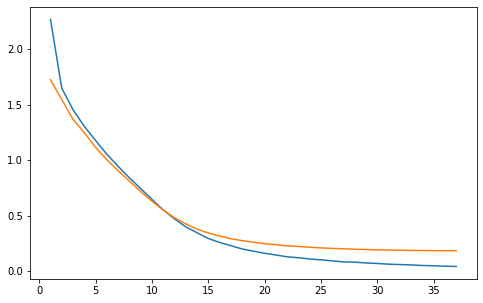

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['loss'])
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_loss'])
plt.show()

In [ ]:
def predict(input_sentence):
    out_text = ''
    seq = tknizer_ita.texts_to_sequences([input_sentence]) 
    pad = pad_sequences(seq, maxlen = 20, dtype='int32', padding='post')
    enc_out, state_h, state_c = model_1.encoder(pad)
    intial = np.zeros((1,1), dtype = 'float32')
    intial[0, 0] = tknizer_eng.word_index['<start>']
    states = [state_h, state_c]
    
    for i in range(20):
        predicted_out, state_h, state_c = model_1.decoder(intial, initial_states = states)
        out = model_1.dense(predicted_out).numpy()
        out = out.reshape(out.shape[-1])
        states = [state_h, state_c] # Update State
        out = np.argmax(out)
        intial = np.zeros((1, 1), dtype = 'float32')
        if tknizer_eng.index_word[out] == '<end>' or i == 20:
            break
        intial[0, 0] = out #Update decoder input
        out_text += tknizer_eng.index_word[out] + ' '
    return out_text

In [ ]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
m = np.random.randint(0, len(val), 10)
for n in tqdm(m):
    query = val.Italian.values[n]
    pred = predict(query)
    ground = val.English_inp.values[n]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 10/10 [00:00<00:00, 27.09it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,hai gi fatto i compiti,did you already do your homework,have you done your homework yet,0.562341
1,tom ha proposto delle soluzioni,did tom propose any solutions,tom is considered the wheel,0.668740
2,pensa che durer a lungo,do you think it will last long,do you think it will last long,1.000000
3,controlla di nuovo la settimana prossima,check back next week,check next week now,0.707107
4,cosa te lo fa credere,what led you to believe so,what makes you believe that,0.720575
5,ci sar della resistenza,will there be resistance,there will be there by,0.880112
6,pensavo fossi sposata,i thought you were married,i thought you were married,1.000000
7,noi abbiamo fatto del nostro meglio per aiutar...,we tried our best to help tom,we did our best to help tom,0.643459
8,tom chi sta visitando,who is tom visiting,tom is visiting,0.716531
9,siamo andati a roma dove siamo rimasti una set...,we went to rome where we stayed a week,we went to rome for this weekend,0.308958


In [ ]:
model_1_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_1_bleu_score)

Average Bleu Score:  0.7207822465459544


## Including Attention mechanism

### <font color='blue'>**Implement custom encoder decoder and attention layers with dot product mechanism**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")

    def call(self,input_sequence,states=None):
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c
        
    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,scoring_function, att_units):
        self.scoring_function = scoring_function
        self.att_units = att_units
        self.softmax = Activation('softmax')
    
        if self.scoring_function=='dot':
            pass
        if scoring_function == 'general':
            self.w = Dense(self.att_units)
  
    def call(self, decoder_hidden_state, encoder_output): 
        
        if self.scoring_function == 'dot':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
            score = tf.matmul(encoder_output,decoder_hidden_state)
            
        elif self.scoring_function == 'general':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
            score = tf.matmul(self.w(encoder_output), decoder_hidden_state)
            
        alpha = self.softmax(score, axis = 1)
        context_vec = alpha * encoder_output
        context_vec = tf.reduce_sum(context_vec, axis = 1)
        return context_vec, alpha

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.score_fun = score_fun
        self.att_units = att_units
        self.dec_units = dec_units
        self.embed = Embedding(input_dim = self.tar_vocab_size, output_dim = self.embedding_dim,
                               input_length = self.input_length)
        self.lstm = LSTM(units = self.dec_units, return_sequences = True, return_state = True)
        self.attention = Attention(self.score_fun, self.att_units)
        self.dense = Dense(self.tar_vocab_size)
        
    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        emb = self.embed(input_to_decoder)
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        dec_inp = tf.concat([tf.expand_dims(context_vector, 1), emb], -1)
        lstm_out, state_h, state_c = self.lstm(dec_inp, [state_h, state_c])
        output = self.dense(lstm_out)
        output = tf.squeeze(output, 1)
        return output, state_h, state_c, attention_weights, context_vector

<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.score_fun = score_fun
        self.att_units = att_units
        self.dec_units = dec_units
        self.one_step = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units ,
                                         self.score_fun ,self.att_units)

    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(input_to_decoder)[1])
        for n in range(tf.shape(input_to_decoder)[1]):
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step(input_to_decoder[:,n:n+1],
                                                                                        encoder_output, 
                                                                                        decoder_hidden_state, 
                                                                                        decoder_cell_state)
            all_outputs = all_outputs.write(n, output)
        all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])            

        return all_outputs 

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, score_fun, att_units, batch_size, embed_size, lstm_size):
        
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1,embedding_size = embed_size, lstm_size = lstm_size,
                               input_length = 20)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_dim = embed_size, input_length = 20,
                               dec_units = lstm_size, score_fun = score_fun, att_units = att_units)
        self.att_units = att_units
        self.batch_size = batch_size
    
    def call(self, data):
        
        inp, targ = data[0], data[1]
        state_h, state_c = self.encoder.initialize_states(self.batch_size)
        enc_out, state_h, state_c = self.encoder(inp, [state_h, state_c])
        dec_out = self.decoder(targ, enc_out, state_h, state_c)

        return dec_out 

<font color='blue'>**Custom loss function**</font>

In [ ]:
def custom_lossfunction(targets, logits):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    loss_ = loss_object(targets, logits)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

In [ ]:
bs = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20, 20)
test_dataset  = Dataset(val, tknizer_ita, tknizer_eng, 20, 20)

train_dataloader = Dataloder(train_dataset, batch_size = bs)
test_dataloader = Dataloder(test_dataset, batch_size = bs)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
model_2 = encoder_decoder(score_fun = 'dot', att_units = 512, batch_size = bs, embed_size = 300, lstm_size = 512)
opt = tf.keras.optimizers.Adam()
model_2.compile(opt, custom_lossfunction)

In [ ]:
model_2.fit(train_dataloader, steps_per_epoch = 150, epochs = 50, callbacks = [early], validation_steps = 40,
            validation_data = test_dataloader)

Epoch 1/50
150/150 [==============================] - 154s 1s/step - loss: 1.8271 - val_loss: 1.6848
Epoch 2/50
150/150 [==============================] - 151s 1s/step - loss: 1.6447 - val_loss: 1.5838
Epoch 3/50
150/150 [==============================] - 150s 1000ms/step - loss: 1.5464 - val_loss: 1.5015
Epoch 4/50
150/150 [==============================] - 155s 1s/step - loss: 1.4549 - val_loss: 1.3822
Epoch 5/50
150/150 [==============================] - 155s 1s/step - loss: 1.2922 - val_loss: 1.1841
Epoch 6/50
150/150 [==============================] - 155s 1s/step - loss: 1.0854 - val_loss: 0.9931
Epoch 7/50
150/150 [==============================] - 155s 1s/step - loss: 0.8962 - val_loss: 0.8233
Epoch 8/50
150/150 [==============================] - 155s 1s/step - loss: 0.7347 - val_loss: 0.6821
Epoch 9/50
150/150 [==============================] - 151s 1s/step - loss: 0.5963 - val_loss: 0.5669
Epoch 10/50
150/150 [==============================] - 152s 1s/step - loss: 0.4868 - va

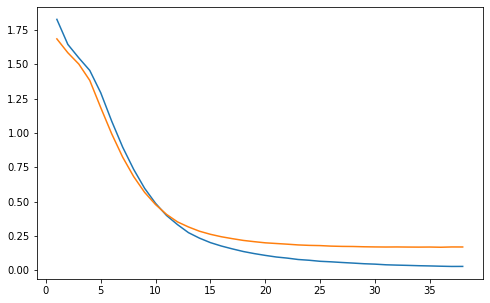

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_2.history.epoch)+1, model_2.history.history['loss'])
plt.plot(np.array(model_2.history.epoch)+1, model_2.history.history['val_loss'])
plt.show()

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  attention = attention[:len(predicted_sentence), :len(sentence), 0]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence, model, plot = False):
    seq = tknizer_ita.texts_to_sequences([input_sentence])
    pad = pad_sequences(seq, 20, padding = 'post', truncating = 'post')
    state_h, state_c = model.layers[0].initialize_states(1)
    enc_out, state_h, state_c = model.layers[0](pad, states = [state_h, state_c])
    initial = np.zeros((1,1), dtype = 'float32')
    initial[0, 0] = tknizer_eng.word_index['<start>']
    word = ''
    att = []
    for i in range(20):
        pred, state_h, state_c, attention_weights, _ = model.layers[1].one_step(initial, enc_out, state_h, state_c)
        att.append(attention_weights)
        pred = np.argmax(pred)
        out = tknizer_eng.index_word[pred]
        if out == '<end>':
            break
        word += out + ' '
        initial = np.zeros((1,1))
        initial[0, 0] = pred
    if plot == True:
        plot_attention(np.vstack(att), input_sentence, word)    
    return word

,Ground Truth,Input,Predict
0,thank you for the wonderful gift,grazie per il meraviglioso regalo,thank you for the gift
1,tom is gullible is not he,tom ingenuo vero,tom is naive is not he
2,why did tom do it,perch tom l ha fatta,why did tom do it
3,who stole the apples,chi ha rubato le mele,who stole the apples
4,are you done with your homework,ha finito i suoi compiti,have you finished your homework


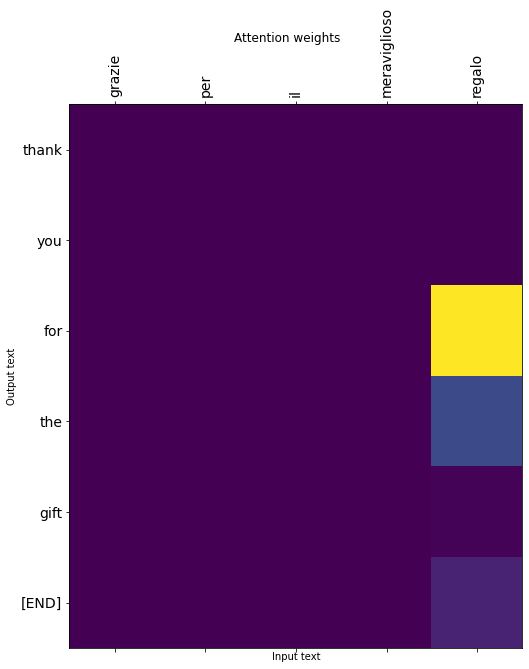

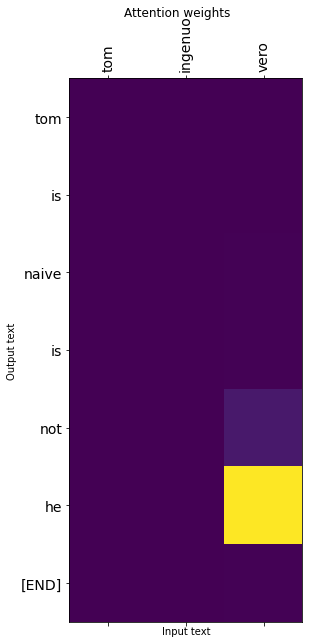

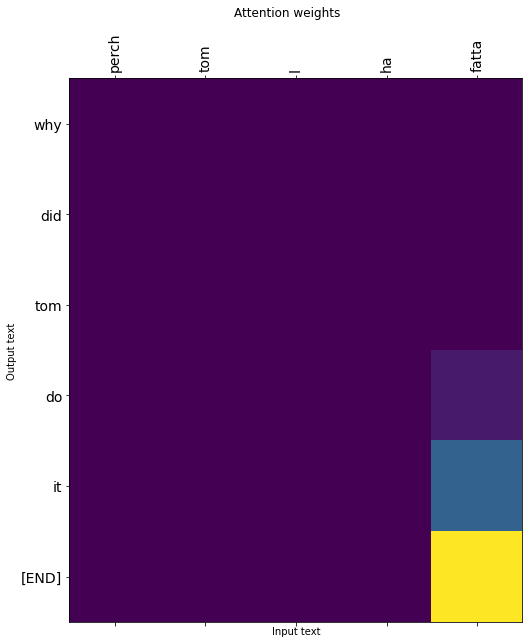

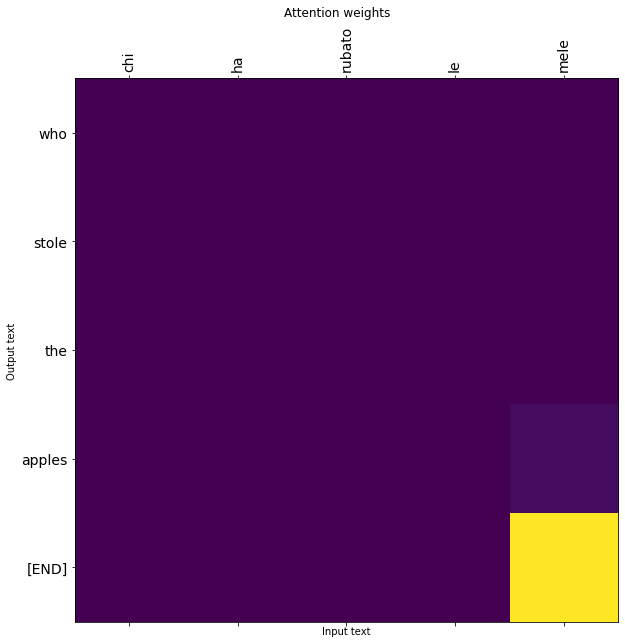

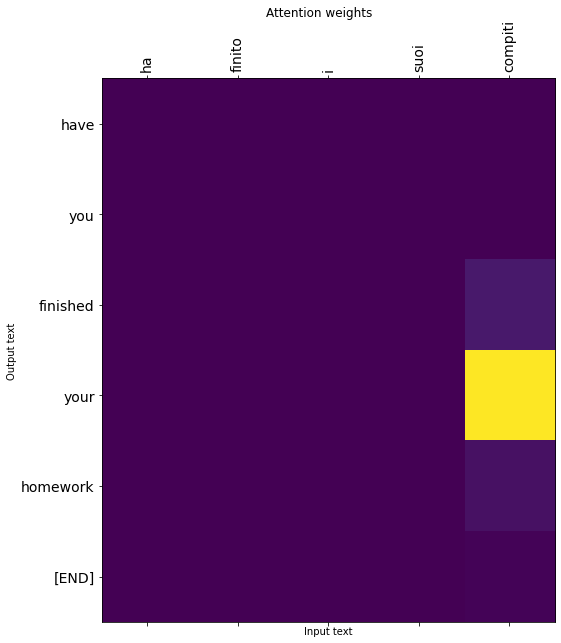

In [ ]:
df = pd.DataFrame()
samples = val.sample(5)
X = samples.Italian.values
Y = samples.English_inp.values
for i in range(5):
    pred = predict(X[i], model_2 , plot = True)
    df = df.append({'Input': X[i], 'Predict': pred, 'Ground Truth': Y[i][8:]}, ignore_index = True)
df

In [ ]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
X = val.Italian.values
Y = val.English_inp.values
m = np.random.randint(0, len(val), 1000)
for n in tqdm(m):
    query = X[n]
    pred = predict(query, model_2, plot = False)
    ground = Y[n]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,la cosa pi stupida che abbia mai detto,that is the stupidest thing i have ever said,that is the dumbest thing i have ever said,0.596949
1,per poter fare richiesta dovete andare di persona,in order to apply you have to go in person,in order to apply you have to go in person,1.000000
2,perch a tom piace lavorare qui,why does tom like working here,why does tom like working here,1.000000
3,firmate in basso per favore,sign at the bottom please,sign at the bottom please,1.000000
4,vorrei noleggiare un automobile,i would like to rent a car,i would like to rent a car,1.000000
...,...,...,...,...
995,l ho incontrata mentre tornavo a casa,i met her on my way home,i met her on my way home,1.000000
996,insegna l inglese al suo amico,he teaches english to his friend,he teaches english to his friend,1.000000
997,mi sento piuttosto al sicuro qui,i feel pretty safe here,i feel pretty safe here,1.000000
998,torn all hotel,he went back to the hotel,he went back to the hotel,1.000000


In [ ]:
model_2_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_2_bleu_score)

Average Bleu Score:  0.8572820332782237


### <font color='blue'>**Implement custom encoder decoder and attention layers with general mechanism**</font>

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
model_3 = encoder_decoder(score_fun = 'general', att_units = 512, batch_size = bs, embed_size = 300, lstm_size = 512)
opt = tf.keras.optimizers.Adam()
model_3.compile(opt, custom_lossfunction)

In [ ]:
model_3.fit(train_dataloader, steps_per_epoch = 150, epochs = 50, callbacks = [early], validation_steps = 40,
            validation_data = test_dataloader)

Epoch 1/50
150/150 [==============================] - 109s 729ms/step - loss: 1.8221 - val_loss: 1.6959
Epoch 2/50
150/150 [==============================] - 109s 727ms/step - loss: 1.6506 - val_loss: 1.6048
Epoch 3/50
150/150 [==============================] - 107s 715ms/step - loss: 1.5440 - val_loss: 1.4946
Epoch 4/50
150/150 [==============================] - 107s 715ms/step - loss: 1.4287 - val_loss: 1.3728
Epoch 5/50
150/150 [==============================] - 106s 709ms/step - loss: 1.2757 - val_loss: 1.1802
Epoch 6/50
150/150 [==============================] - 107s 713ms/step - loss: 1.0694 - val_loss: 0.9773
Epoch 7/50
150/150 [==============================] - 107s 713ms/step - loss: 0.8749 - val_loss: 0.8078
Epoch 8/50
150/150 [==============================] - 106s 708ms/step - loss: 0.7160 - val_loss: 0.6712
Epoch 9/50
150/150 [==============================] - 106s 710ms/step - loss: 0.5851 - val_loss: 0.5597
Epoch 10/50
150/150 [==============================] - 107s 713m

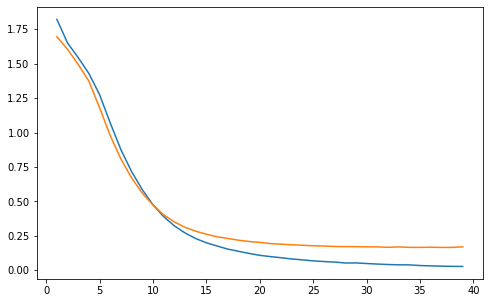

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_3.history.epoch)+1, model_3.history.history['loss'])
plt.plot(np.array(model_3.history.epoch)+1, model_3.history.history['val_loss'])
plt.show()

,Ground Truth,Input,Predict
0,tom sat on the curb,tom sedeva sul bordo del marciapiede,tom sat on the edge of the sidewalk
1,the child pointed out her mother to me,il bambino mi ha indicato sua mandre,the child pointed to me her
2,it smells like a trap,odora di trappola,it smells like that
3,i do not have any real choice,io non ho alcuna vera scelta,i have no real choice
4,we were just studying,noi stavamo solo studiando,we were just studying


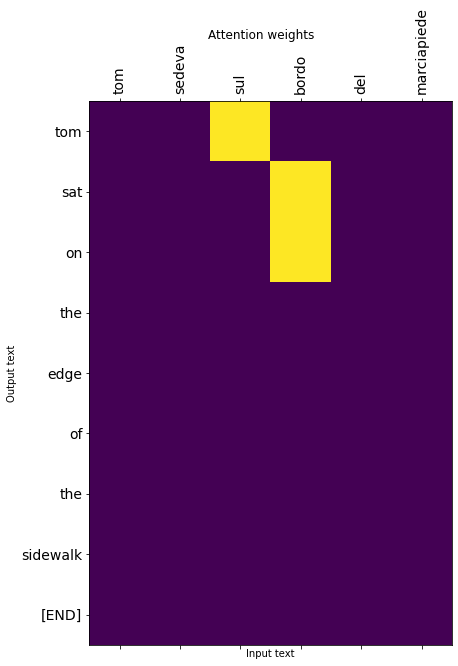

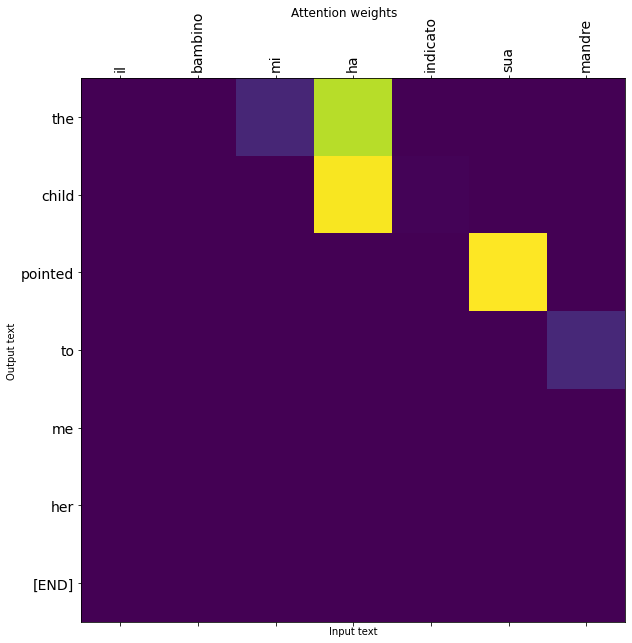

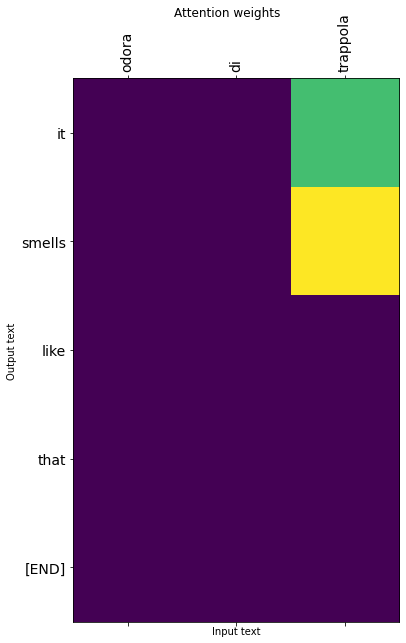

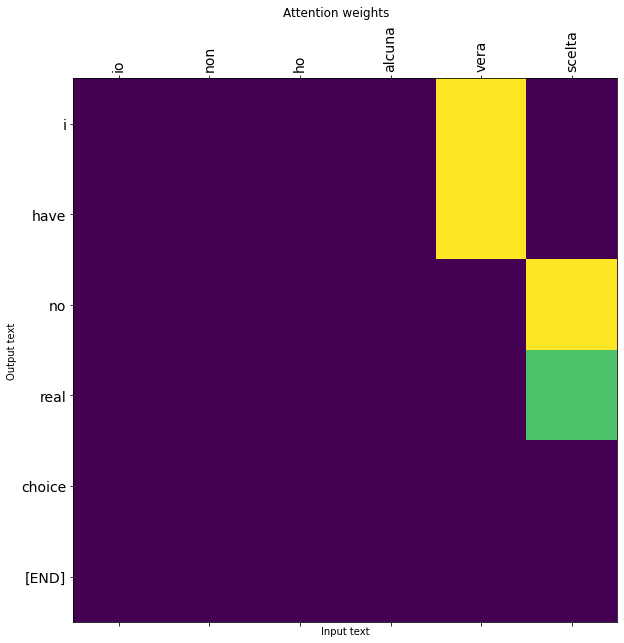

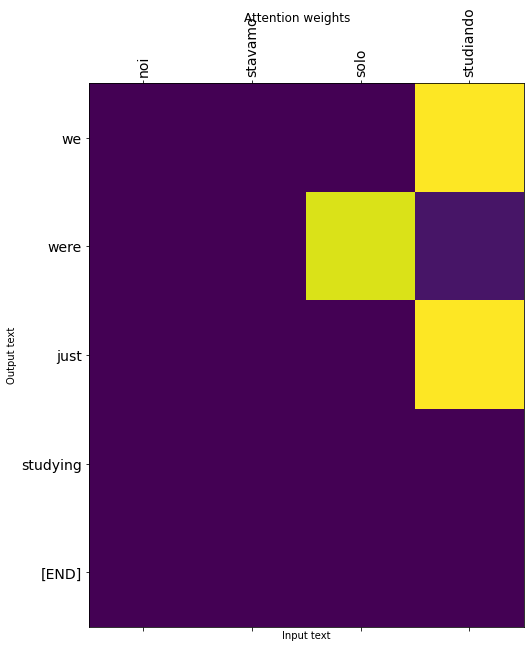

In [ ]:
df = pd.DataFrame()
samples = val.sample(5)
X = samples.Italian.values
Y = samples.English_inp.values
for i in range(5):
    pred = predict(X[i], model_3 , plot = True)
    df = df.append({'Input': X[i], 'Predict': pred, 'Ground Truth': Y[i][8:]}, ignore_index = True)
df

In [ ]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
X = val.Italian.values
Y = val.English_inp.values
m = np.random.randint(0, len(val), 1000)
for n in tqdm(m):
    query = X[n]
    pred = predict(query, model_3, plot = False)
    ground = Y[n]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 1000/1000 [01:06<00:00, 14.93it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,questo non abbastanza,this is not enough,this is not enough,1.000000
1,sono molto alta,i am very tall,i am very tall,1.000000
2,ehi vi stavo per chiamare,hey i was going to call you,hey i was going to call you,1.000000
3,non mi piace per niente il poker,i do not like poker at all,i do not like poker at all,1.000000
4,sta accadendo qualcosa,there is something going on,is there anything happening,0.654891
...,...,...,...,...
995,ci sono abituata ora,i am used to it now,i am used to it now,1.000000
996,potreste farmi un favore,could you do me a favor,could you do me a favor,1.000000
997,ero infastidito dalla pigrizia del ragazzo,i was annoyed with the boy for being lazy,i was annoyed with the boy for being lazy,1.000000
998,io odiavo gli spinaci,i used to hate spinach,i hated spinach,0.463925


In [ ]:
model_3_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_3_bleu_score)

Average Bleu Score:  0.8574501796666246
